In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm

In [2]:
df = pd.read_pickle("data/flickr_data_with_features.pkl")

with open("data/tags_to_delete.txt", "r") as f:
    tags_to_delete = set(line.strip() for line in f)

In [3]:
YEAR = "all"
ONLY_SIMILAR_YEARS = True

sample = None
if YEAR == "all":
    sample = df.copy()
else:
    sample = df[df["date_taken"].dt.year == YEAR].copy()

if ONLY_SIMILAR_YEARS:
    sample = sample[sample["similar_year"] == 1]

coords = sample[["lat", "long"]].values

K_RANGE = range(30, 150)
inertias = []
silhouette_scores = []

for k in tqdm(K_RANGE):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

100%|██████████| 120/120 [05:51<00:00,  2.93s/it]


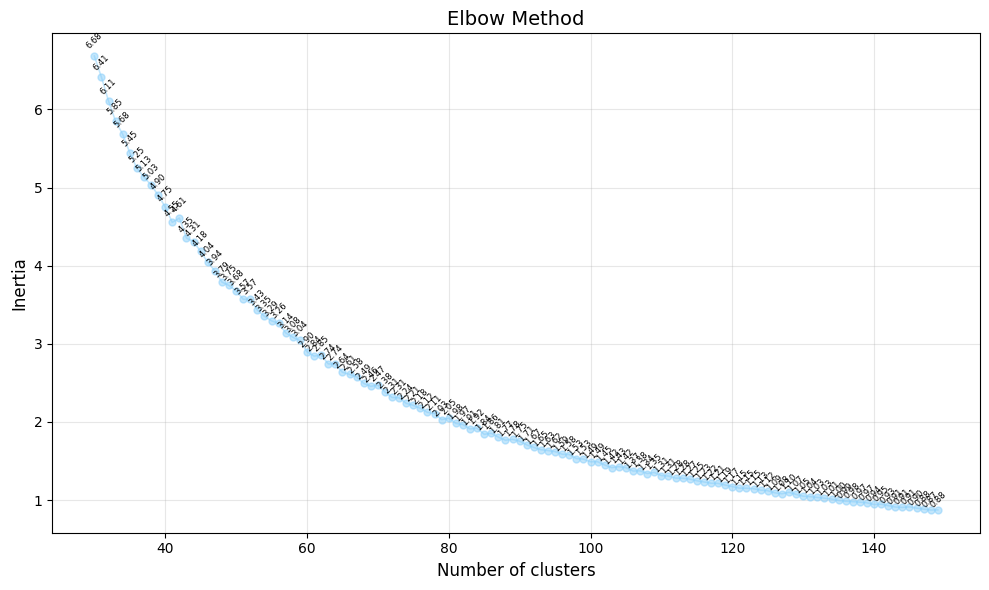

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_RANGE, inertias, 'o-', linewidth=1.15, markersize=5, alpha=0.5, color="lightskyblue")
ax.set_xlabel("Number of clusters", fontsize=12)
ax.set_ylabel("Inertia", fontsize=12)
ax.set_title("Elbow Method", fontsize=14)
ax.grid(True, alpha=0.3)

for i, (k, inertia) in enumerate(zip(K_RANGE, inertias)):
    ax.text(k, inertia * 1.01, f"{inertia:.2f}", ha='center', va='bottom', fontsize=6, rotation=45)

plt.tight_layout()
plt.show()

In [5]:
N_CLUSTERS = 120

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
sample["cluster"] = kmeans.fit_predict(coords)

# Calculate inertia contribution for each point
distances = kmeans.transform(coords)
min_distances = np.min(distances, axis=1)

# Set 5% of points with highest distance to cluster -1 (noise)
threshold_percentile = 95
threshold = np.percentile(min_distances, threshold_percentile)
sample.loc[min_distances >= threshold, "cluster"] = -1

n_clusters = len(set(sample["cluster"])) - (1 if -1 in sample["cluster"] else 0)
n_noise = list(sample["cluster"]).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points (top 5%): {n_noise}")
print(f"\nCluster distribution:")
print(sample["cluster"].value_counts().sort_index())

Number of clusters: 118
Number of noise points (top 5%): 8710

Cluster distribution:
cluster
-1       8710
 0         55
 1       1565
 2       1427
 3      14866
        ...  
 115      207
 116       18
 117     2765
 118       82
 119     3010
Name: count, Length: 118, dtype: int64


In [6]:
N_TOP_TAGS = 5

cluster_top_tags = get_cluster_top_tags(sample, tags_to_delete, N_TOP_TAGS)
print(f"\nTop {N_TOP_TAGS} tags per cluster:")
for cluster_id in sorted(cluster_top_tags.keys()):
    print(f"Cluster {cluster_id}: {', '.join(cluster_top_tags[cluster_id])}")


Top 5 tags per cluster:
Cluster 0: saintefoyleslyon, figurationlibre, supportssurfaces, donquichotte, lépéelaplumeetlepinceau
Cluster 1: rhône, streetart, street, art, 6ème
Cluster 2: cosplay, japactu, japactuinfo, japantouch, cosplayjapactu
Cluster 3: demeureduchaos, abodeofchaos, thierryehrmann, alchemy, prophecy
Cluster 4: vieuxlyon, saône, river, saintgeorges, architecture
Cluster 5: rhône, artnouveau, jacquesgrüber, villaberliet, louismajorelle
Cluster 6: macro, fleur, mural, mur, peint
Cluster 7: onlylyon, sculpture, artcontemporain, usinesfagor, biennale
Cluster 8: stadium, stade, ol, décinescharpieu, art
Cluster 9: musée, confluence, rhône, muséedesconfluences, confluences
Cluster 10: uploaded:by=flickrmobile, icedteafilter, flickriosapp:filter=icedtea, church, eglise
Cluster 11: parcdelatêtedor, parc, zoo, animal, dor
Cluster 12: d300, 50mmf14g, thedigitalfly, lotfidakhli, afs50mm14g
Cluster 13: vlr, square, hudson
Cluster 14: square, foursquare:venue=4be26f00b02ec9b6a1004dc0

In [7]:
# Create and save map
save_dir = Path("./data/kmeans/")
save_dir.mkdir(parents=True, exist_ok=True)
create_cluster_map(sample=sample, cluster_top_tags=cluster_top_tags, year=YEAR, show_noise=False, show_points=False, save_dir=save_dir)

Cluster map saved to data/kmeans/all_clusters_map.html
